# PIPELINE
 DATALOADER --> GRAPH CONSTRUCTION --> GNN --> EXPLAIN 

## DataLoader

In [1]:
from torch.utils.data import Dataset
import os 
from PIL import Image

In [2]:
class CUB (Dataset):
    '''
    parts 
        part_locs 
        parts (names)
    images 
        200 classes
    bounding box  (for cropping images)
    classes.txt
    train_test_split.txt
    image_class_labels.txt
    
    '''

    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir # D:\TorchProject\dataset\cub\CUB_200_2011
        self.transform = transform
        self.image_dir = os.path.join(root_dir,'images')
        self.image_mapping = self._load_image_mapping()
        self.label_mapping = self._load_label_mapping()
        self.part_locs_mapping = self._load_part_locs_mapping()
        self.part_name_mapping = self._load_part_name_mapping()
        self.bounding_box_mapping = self._load_bounding_box()
        #self.classes_name = self._load_class_names()
    
    # def _load_class_names(self):
    #     class_names = {}
    #     classes_file = os.path.join(self.root_dir,'classes.txt')
    #     with open(classes_file, 'r') as file:
    #         for line in file:
    #             class_id, class_name = line.strip().split()
    #             if class_id not in class_names:
    #                 class_names[class_id] = {}
    #             class_names[class_id] = class_name
    #     return class_names

    def _load_bounding_box(self):
        bounding_box = {}
        box_file = os.path.join(self.root_dir, 'bounding_boxes.txt')
        with open(box_file, 'r') as file:
            for line in file:
                image_id, x, y, width, height = line.strip().split()
                bounding_box[image_id] = [float(x), float(y), float(width), float(height)]
        return bounding_box

    def _load_part_name_mapping (self):
        part_names = {}
        part_names_path = os.path.join(self.root_dir, 'parts', 'parts.txt')
        with open(part_names_path, 'r') as file:
            for line in file:
                part_id, part_name = line.strip().split()
                part_names[part_id] = {}
                part_names[part_id] = part_name
        return part_names
              
    def _load_part_locs_mapping (self):
        part_locs_mapping = {}
        part_locs = os.path.join(self.root_dir, 'parts', 'part_locs.txt')
        with open(part_locs, 'r') as file:
            for line in file:
                image_id, part_id, x, y, _ = line.strip().split()
                if image_id not in part_locs_mapping:
                    part_locs_mapping[image_id] = {}
                part_locs_mapping[image_id][part_id] = [float (x), float (y)]
        return part_locs_mapping

    def _load_label_mapping (self):
        label_mapping = {}
        label_file = os.path.join(self.root_dir,'image_class_labels.txt')
        with open(label_file, 'r') as file:
            for line in file:
                image_id, label_id = line.strip().split()
                label_mapping[image_id] = int(label_id)
        return label_mapping

    def _load_image_mapping (self):
        image_mapping = {}
        image_file = os.path.join(self.root_dir,'images.txt')
        with open(image_file, 'r') as file:
            for line in file:
                image_id, image_name = line.strip().split()
                image_mapping[image_id] = image_name
        return image_mapping

    def __len__(self):
        return len(self.image_mapping)

    def __getitem__(self, index):
        label = self.label_mapping[str(index+1)]
        part_locs = self.part_locs_mapping.get(str(index), [])
        image_name = self.image_mapping[str(index)]
        bboxes = self.bounding_box_mapping.get(str(index), [])
        #part_name = self.part_name_mapping.get(str(index),[])
        image= Image.open(os.path.join(self.image_dir,image_name)).convert('RGB')
        
        # Didnt check if this task is done right, because no need to be in here currently 
        # class_names_list= []
        # class_names = self.class_names.get(str(index), [])
        # for int (i) in class_names:
        #     class_names_list.append(class_names[i])
        
        part_name_list = []
        part_name_dict = {}
        for key in part_locs:
            part_name = self.part_name_mapping.get(str(key),[])
            part_name_dict[part_name] = part_locs[key]
            part_name_list.append(part_name)

        if self.transform:
           image = self.transform(image)
#        return (image, label,part_name, part_locs, bboxes, part_name_list, part_name_dict)
        return (image, label, part_locs, bboxes, part_name_dict) #, class_names    # why has to have part_locs to display right the location?
    # dict: 'back': [0.0, 0.0],'beak': [312.0, 182.0], 'belly': [0.0, 0.0], 'breast': [0.0, 0.0], 'crown': [186.0, 45.0],..
    # locs: '8': [0.0, 0.0], '9': [0.0, 0.0], '10': [100.0, 221.0], '11': [183.0, 101.0], '12': [0.0, 0.0], '13': [0.0, 0.0], ..

In [3]:
### for testing

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader

root_dir = 'D:\TorchProject\dataset\cub\CUB_200_2011'
# run dataset == __init__
dataset = CUB(root_dir) # --> load sample to check
dataloader = DataLoader(dataset, batch_size=2, shuffle=False) #divide dataset by batch
image, label, part_locs, bboxes, part_name_dict = dataset[1]

print(dataset[1])

(<PIL.Image.Image image mode=RGB size=500x335 at 0x20EA5673FD0>, 1, {'1': [0.0, 0.0], '2': [312.0, 182.0], '3': [0.0, 0.0], '4': [0.0, 0.0], '5': [186.0, 45.0], '6': [247.0, 79.0], '7': [0.0, 0.0], '8': [0.0, 0.0], '9': [0.0, 0.0], '10': [100.0, 221.0], '11': [183.0, 101.0], '12': [0.0, 0.0], '13': [0.0, 0.0], '14': [0.0, 0.0], '15': [215.0, 194.0]}, [60.0, 27.0, 325.0, 304.0], {'back': [0.0, 0.0], 'beak': [312.0, 182.0], 'belly': [0.0, 0.0], 'breast': [0.0, 0.0], 'crown': [186.0, 45.0], 'forehead': [247.0, 79.0], 'left_eye': [0.0, 0.0], 'left_leg': [0.0, 0.0], 'left_wing': [0.0, 0.0], 'nape': [100.0, 221.0], 'right_eye': [183.0, 101.0], 'right_leg': [0.0, 0.0], 'right_wing': [0.0, 0.0], 'tail': [0.0, 0.0], 'throat': [215.0, 194.0]})


### Visualize

11788
1 {'back': [0.0, 0.0], 'beak': [312.0, 182.0], 'belly': [0.0, 0.0], 'breast': [0.0, 0.0], 'crown': [186.0, 45.0], 'forehead': [247.0, 79.0], 'left_eye': [0.0, 0.0], 'left_leg': [0.0, 0.0], 'left_wing': [0.0, 0.0], 'nape': [100.0, 221.0], 'right_eye': [183.0, 101.0], 'right_leg': [0.0, 0.0], 'right_wing': [0.0, 0.0], 'tail': [0.0, 0.0], 'throat': [215.0, 194.0]} {'1': [0.0, 0.0], '2': [312.0, 182.0], '3': [0.0, 0.0], '4': [0.0, 0.0], '5': [186.0, 45.0], '6': [247.0, 79.0], '7': [0.0, 0.0], '8': [0.0, 0.0], '9': [0.0, 0.0], '10': [100.0, 221.0], '11': [183.0, 101.0], '12': [0.0, 0.0], '13': [0.0, 0.0], '14': [0.0, 0.0], '15': [215.0, 194.0]} [60.0, 27.0, 325.0, 304.0]


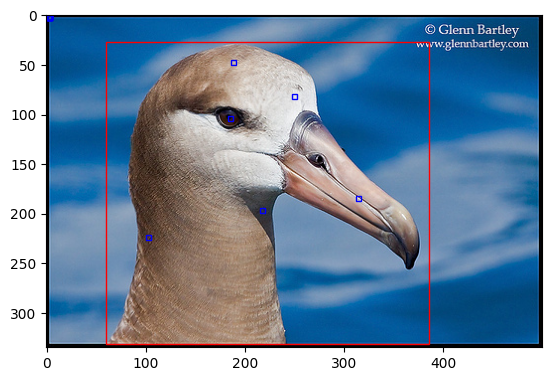

1 {'back': [228.0, 138.0], 'beak': [282.0, 154.0], 'belly': [0.0, 0.0], 'breast': [248.0, 158.0], 'crown': [266.0, 141.0], 'forehead': [272.0, 144.0], 'left_eye': [0.0, 0.0], 'left_leg': [0.0, 0.0], 'left_wing': [208.0, 102.0], 'nape': [256.0, 141.0], 'right_eye': [270.0, 146.0], 'right_leg': [0.0, 0.0], 'right_wing': [234.0, 193.0], 'tail': [163.0, 155.0], 'throat': [260.0, 155.0]} {'1': [228.0, 138.0], '2': [282.0, 154.0], '3': [0.0, 0.0], '4': [248.0, 158.0], '5': [266.0, 141.0], '6': [272.0, 144.0], '7': [0.0, 0.0], '8': [0.0, 0.0], '9': [208.0, 102.0], '10': [256.0, 141.0], '11': [270.0, 146.0], '12': [0.0, 0.0], '13': [234.0, 193.0], '14': [163.0, 155.0], '15': [260.0, 155.0]} [139.0, 30.0, 153.0, 264.0]


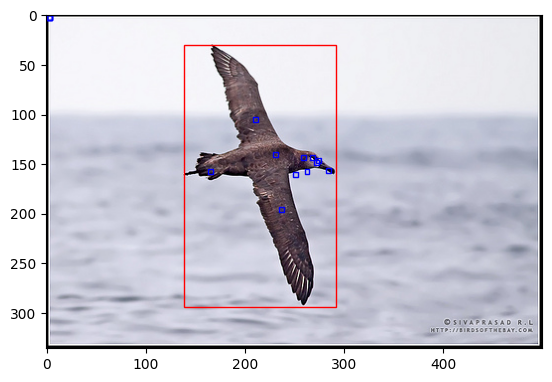

1 {'back': [227.0, 213.0], 'beak': [376.0, 160.0], 'belly': [0.0, 0.0], 'breast': [325.0, 243.0], 'crown': [324.0, 121.0], 'forehead': [349.0, 128.0], 'left_eye': [0.0, 0.0], 'left_leg': [0.0, 0.0], 'left_wing': [170.0, 198.0], 'nape': [288.0, 169.0], 'right_eye': [336.0, 136.0], 'right_leg': [0.0, 0.0], 'right_wing': [199.0, 237.0], 'tail': [42.0, 201.0], 'throat': [327.0, 174.0]} {'1': [227.0, 213.0], '2': [376.0, 160.0], '3': [0.0, 0.0], '4': [325.0, 243.0], '5': [324.0, 121.0], '6': [349.0, 128.0], '7': [0.0, 0.0], '8': [0.0, 0.0], '9': [170.0, 198.0], '10': [288.0, 169.0], '11': [336.0, 136.0], '12': [0.0, 0.0], '13': [199.0, 237.0], '14': [42.0, 201.0], '15': [327.0, 174.0]} [14.0, 112.0, 388.0, 186.0]


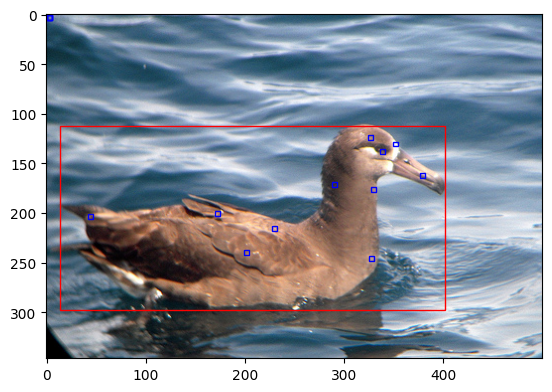

1 {'back': [221.0, 179.0], 'beak': [126.0, 203.0], 'belly': [0.0, 0.0], 'breast': [190.0, 215.0], 'crown': [157.0, 180.0], 'forehead': [145.0, 187.0], 'left_eye': [153.0, 189.0], 'left_leg': [0.0, 0.0], 'left_wing': [238.0, 245.0], 'nape': [182.0, 183.0], 'right_eye': [0.0, 0.0], 'right_leg': [0.0, 0.0], 'right_wing': [235.0, 133.0], 'tail': [337.0, 211.0], 'throat': [174.0, 207.0]} {'1': [221.0, 179.0], '2': [126.0, 203.0], '3': [0.0, 0.0], '4': [190.0, 215.0], '5': [157.0, 180.0], '6': [145.0, 187.0], '7': [153.0, 189.0], '8': [0.0, 0.0], '9': [238.0, 245.0], '10': [182.0, 183.0], '11': [0.0, 0.0], '12': [0.0, 0.0], '13': [235.0, 133.0], '14': [337.0, 211.0], '15': [174.0, 207.0]} [112.0, 90.0, 255.0, 242.0]


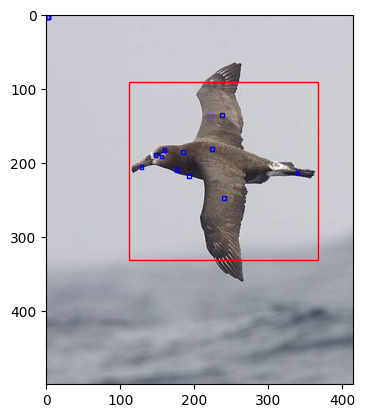

1 {'back': [0.0, 0.0], 'beak': [194.0, 147.0], 'belly': [132.0, 159.0], 'breast': [154.0, 153.0], 'crown': [177.0, 137.0], 'forehead': [183.0, 139.0], 'left_eye': [0.0, 0.0], 'left_leg': [0.0, 0.0], 'left_wing': [137.0, 203.0], 'nape': [166.0, 137.0], 'right_eye': [179.0, 141.0], 'right_leg': [0.0, 0.0], 'right_wing': [138.0, 107.0], 'tail': [76.0, 160.0], 'throat': [175.0, 150.0]} {'1': [0.0, 0.0], '2': [194.0, 147.0], '3': [132.0, 159.0], '4': [154.0, 153.0], '5': [177.0, 137.0], '6': [183.0, 139.0], '7': [0.0, 0.0], '8': [0.0, 0.0], '9': [137.0, 203.0], '10': [166.0, 137.0], '11': [179.0, 141.0], '12': [0.0, 0.0], '13': [138.0, 107.0], '14': [76.0, 160.0], '15': [175.0, 150.0]} [70.0, 50.0, 134.0, 303.0]


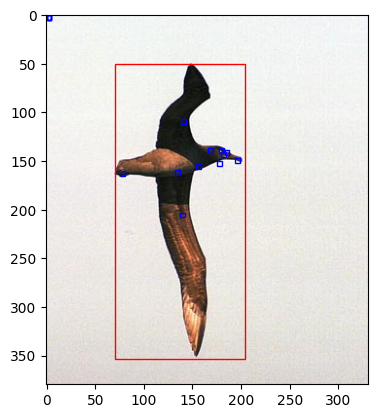

1 {'back': [163.0, 180.0], 'beak': [264.0, 202.0], 'belly': [0.0, 0.0], 'breast': [190.0, 213.0], 'crown': [240.0, 181.0], 'forehead': [253.0, 187.0], 'left_eye': [0.0, 0.0], 'left_leg': [57.0, 190.0], 'left_wing': [193.0, 108.0], 'nape': [221.0, 181.0], 'right_eye': [244.0, 189.0], 'right_leg': [78.0, 226.0], 'right_wing': [126.0, 267.0], 'tail': [82.0, 199.0], 'throat': [228.0, 204.0]} {'1': [163.0, 180.0], '2': [264.0, 202.0], '3': [0.0, 0.0], '4': [190.0, 213.0], '5': [240.0, 181.0], '6': [253.0, 187.0], '7': [0.0, 0.0], '8': [57.0, 190.0], '9': [193.0, 108.0], '10': [221.0, 181.0], '11': [244.0, 189.0], '12': [78.0, 226.0], '13': [126.0, 267.0], '14': [82.0, 199.0], '15': [228.0, 204.0]} [33.0, 53.0, 251.0, 395.0]


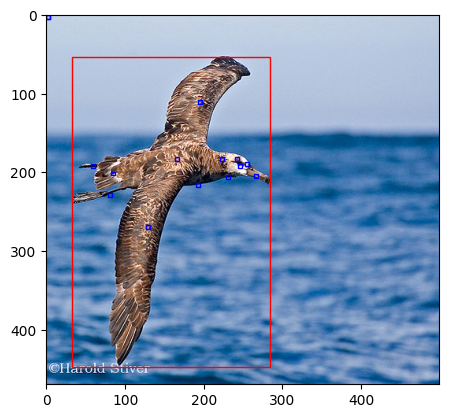

1 {'back': [0.0, 0.0], 'beak': [362.0, 243.0], 'belly': [0.0, 0.0], 'breast': [0.0, 0.0], 'crown': [212.0, 94.0], 'forehead': [290.0, 133.0], 'left_eye': [0.0, 0.0], 'left_leg': [0.0, 0.0], 'left_wing': [0.0, 0.0], 'nape': [116.0, 229.0], 'right_eye': [240.0, 152.0], 'right_leg': [0.0, 0.0], 'right_wing': [0.0, 0.0], 'tail': [0.0, 0.0], 'throat': [251.0, 234.0]} {'1': [0.0, 0.0], '2': [362.0, 243.0], '3': [0.0, 0.0], '4': [0.0, 0.0], '5': [212.0, 94.0], '6': [290.0, 133.0], '7': [0.0, 0.0], '8': [0.0, 0.0], '9': [0.0, 0.0], '10': [116.0, 229.0], '11': [240.0, 152.0], '12': [0.0, 0.0], '13': [0.0, 0.0], '14': [0.0, 0.0], '15': [251.0, 234.0]} [7.0, 75.0, 420.0, 262.0]


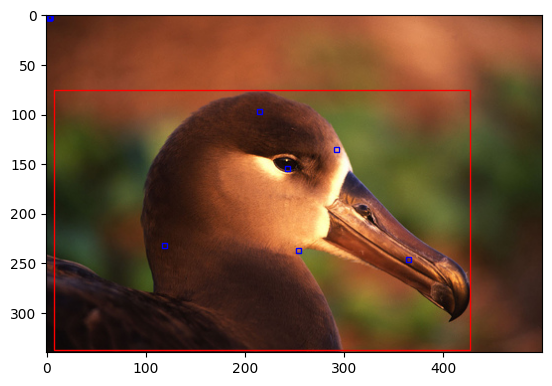

1 {'back': [225.0, 162.0], 'beak': [107.0, 132.0], 'belly': [0.0, 0.0], 'breast': [151.0, 194.0], 'crown': [142.0, 96.0], 'forehead': [120.0, 108.0], 'left_eye': [136.0, 111.0], 'left_leg': [0.0, 0.0], 'left_wing': [246.0, 186.0], 'nape': [175.0, 135.0], 'right_eye': [0.0, 0.0], 'right_leg': [0.0, 0.0], 'right_wing': [0.0, 0.0], 'tail': [388.0, 151.0], 'throat': [145.0, 139.0]} {'1': [225.0, 162.0], '2': [107.0, 132.0], '3': [0.0, 0.0], '4': [151.0, 194.0], '5': [142.0, 96.0], '6': [120.0, 108.0], '7': [136.0, 111.0], '8': [0.0, 0.0], '9': [246.0, 186.0], '10': [175.0, 135.0], '11': [0.0, 0.0], '12': [0.0, 0.0], '13': [0.0, 0.0], '14': [388.0, 151.0], '15': [145.0, 139.0]} [78.0, 86.0, 333.0, 158.0]


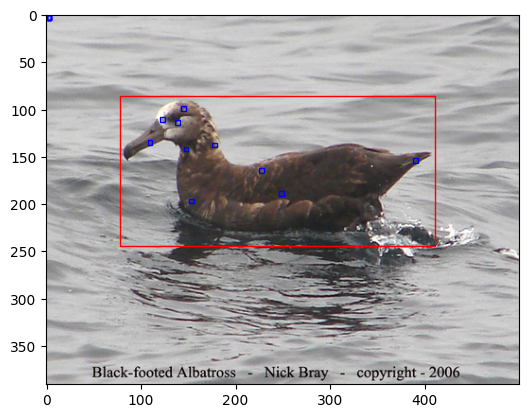

1 {'back': [197.0, 136.0], 'beak': [129.0, 154.0], 'belly': [0.0, 0.0], 'breast': [182.0, 164.0], 'crown': [150.0, 137.0], 'forehead': [140.0, 143.0], 'left_eye': [146.0, 145.0], 'left_leg': [0.0, 0.0], 'left_wing': [215.0, 189.0], 'nape': [169.0, 139.0], 'right_eye': [0.0, 0.0], 'right_leg': [0.0, 0.0], 'right_wing': [228.0, 112.0], 'tail': [298.0, 172.0], 'throat': [153.0, 158.0]} {'1': [197.0, 136.0], '2': [129.0, 154.0], '3': [0.0, 0.0], '4': [182.0, 164.0], '5': [150.0, 137.0], '6': [140.0, 143.0], '7': [146.0, 145.0], '8': [0.0, 0.0], '9': [215.0, 189.0], '10': [169.0, 139.0], '11': [0.0, 0.0], '12': [0.0, 0.0], '13': [228.0, 112.0], '14': [298.0, 172.0], '15': [153.0, 158.0]} [112.0, 76.0, 221.0, 189.0]


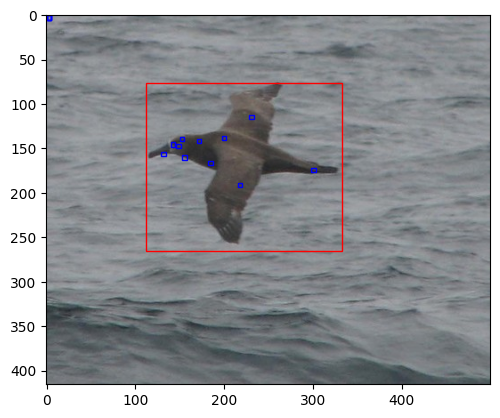

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader

def visualize_bounding_box(image, part_name_dict, bboxes):
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Extract bounding box coordinates
    x, y, width, height = bboxes
    rect_pb = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect_pb)
    # Iterate over part bounding boxes and draw rectangles
    for part_id, part_bb in part_name_dict.items():
        x_pb, y_pb = part_bb
        width_pb, height_pb = 5, 5  # Modify the width and height as per your requirement
        rect_pb = patches.Rectangle((x_pb, y_pb), width_pb, height_pb, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect_pb)

        # Show the plot
    plt.show()


# Example usage

root_dir = 'D:\TorchProject\dataset\cub\CUB_200_2011'
# run dataser == __init__
dataset = CUB(root_dir) # --> load sample to check
dataloader = DataLoader(dataset, batch_size=2, shuffle=False) #divide dataset by batch

# call len  == __len__
print (len(dataset))

for i in range (1,10):
    image, label, part_locs, bboxes, part_name_dict = dataset[i]
    print (label,part_name_dict, part_locs,bboxes)

    # Visualize all bounding boxes
    visualize_bounding_box(image, part_locs, bboxes)

### Take Class names


In [ ]:
# load the classes for embedding text 

root_dir = 'D:\TorchProject\dataset\cub\CUB_200_2011'

CLASS_NAMES = {}
classes_file = os.path.join(root_dir,'classes.txt')
with open(classes_file, 'r') as file:
    for line in file:
        class_id, class_name = line.strip().split()
        if class_id not in CLASS_NAMES:
            CLASS_NAMES[class_id] = {}
        CLASS_NAMES[class_id] = class_name
print(CLASS_NAMES)

for i in range (1,201):
    print (CLASS_NAMES[str(i)])

### Take the Part names

In [ ]:
# load the parts for embedding text 

root_dir = 'D:\TorchProject\dataset\cub\CUB_200_2011'

PART_NAMES = {}
parts_file = os.path.join(root_dir,'parts','parts.txt')
with open(parts_file, 'r') as file:
    for line in file:
        part_id, part_name = line.strip().split()
        if part_id not in PART_NAMES:
            PART_NAMES[part_id] = {}
        PART_NAMES[part_id] = part_name
print(PART_NAMES)

for i in range (1,len(PART_NAMES)+1):
    print (PART_NAMES[str(i)])

### BERT library

In [ ]:
# embedding by BERT
import torch
from transformers import BertTokenizer, BertModel

class TextEmbedder:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased')
    
    def embed_text(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling over tokens
        return embeddings
    
    
### Test 
# Initialize the TextEmbedder
text_embedder = TextEmbedder()

embedded_class_names = {}
# Example class names
for i in range (1,len(CLASS_NAMES)+1):
    embedded_class_names[i] = (text_embedder.embed_text(CLASS_NAMES[str(i)]))

# Print the embeddings
#print(embedded_class_names)


embedded_part_names = {}
for i in range (1,len(PART_NAMES)+1):
    embedded_part_names[i] = (text_embedder.embed_text(CLASS_NAMES[str(i)]))
    
# Print the embeddings
#print(embedded_part_names)

In [ ]:
# check embedded tensor 

#len(embedded_class_names)
#embedded_class_names[100]
embedded_class_names[1].shape

### Resize image to use ViT - not tested yet

In [ ]:
from PIL import Image

def resize_image(image, target_size):
    """
    Resize the input image while maintaining its aspect ratio.
    
    Args:
        image (PIL.Image): Input image.
        target_size (tuple): Desired target size (width, height).
    
    Returns:
        PIL.Image: Resized image.
    """
    width, height = image.size
    aspect_ratio = width / height
    target_width, target_height = target_size

    if width > height:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)
    return resized_image


### Update the position of the points in the image  - not tested yet

In [ ]:
def update_points_after_resize(original_size, new_size, points):
    """
    Update points' positions after resizing an image.
    
    Args:
        original_size (tuple): Original image size (width, height).
        new_size (tuple): Resized image size (width, height).
        points (list of tuples): List of (x, y) coordinates of points.
    
    Returns:
        list of tuples: Updated points' positions.
    """
    original_width, original_height = original_size
    new_width, new_height = new_size

    updated_points = []
    for x, y in points:
        new_x = int(x * (new_width / original_width))
        new_y = int(y * (new_height / original_height))
        updated_points.append((new_x, new_y))

    return updated_points


### ViT library  - not tested yet

In [55]:
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification

class ViTHandler:
    def __init__(self, variant='google/vit-base-patch16-224-in21k'):
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(variant)
        self.model = ViTForImageClassification.from_pretrained(variant, output_hidden_states = True)
    
    def process_image(self, image):
        inputs = self.feature_extractor(images=image, return_tensors='pt')
        print ("input: ", inputs)
        with torch.no_grad():
            outputs = self.model(**inputs)
            print("output: ", outputs)
        embeddings = outputs.hidden_states[-1] # take the last hidden state - why? dont know
        return embeddings

### test
# Initialize the ViTHandler with a specific variant
vit_handler = ViTHandler(variant='google/vit-base-patch16-224-in21k')

# TURN IMAGE TO TENSOR (replace this with your image data) 
image_tensor = torch.rand(1, 3, 224, 224)  # Batch size, channels, height, width

# Process the image and obtain visual embeddings
embeddings = vit_handler.process_image(image_tensor)
#print(embeddings.shape)

# Now you can use these embeddings in your Graph Vision Network


c:\Users\An\anaconda3\envs\graph\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


input:  {'pixel_values': tensor([[[[-0.9927, -0.9969, -0.9929,  ..., -0.9994, -0.9922, -0.9937],
          [-0.9977, -0.9980, -0.9990,  ..., -0.9965, -0.9992, -0.9990],
          [-0.9988, -0.9972, -0.9955,  ..., -0.9996, -0.9926, -0.9951],
          ...,
          [-0.9949, -0.9978, -0.9960,  ..., -0.9931, -0.9989, -0.9926],
          [-1.0000, -0.9978, -0.9992,  ..., -0.9929, -0.9992, -0.9954],
          [-0.9947, -0.9923, -0.9969,  ..., -0.9946, -0.9952, -0.9929]],

         [[-0.9968, -0.9941, -0.9942,  ..., -0.9936, -0.9969, -0.9991],
          [-0.9967, -0.9937, -0.9991,  ..., -0.9937, -0.9977, -0.9934],
          [-0.9954, -0.9952, -0.9976,  ..., -0.9966, -0.9957, -0.9963],
          ...,
          [-0.9951, -0.9951, -0.9990,  ..., -0.9936, -0.9975, -0.9992],
          [-0.9931, -0.9998, -0.9928,  ..., -0.9944, -0.9988, -0.9974],
          [-0.9938, -0.9946, -0.9929,  ..., -0.9927, -0.9931, -0.9958]],

         [[-0.9994, -0.9942, -0.9923,  ..., -0.9983, -0.9984, -0.9922],
     

### Graph Construction
- Node (1 -> 15)
- Node (16 -> 216)
- Edges (init)

- load the class names from classes.txt file & part names from parts.txt file [done]
- embedding each class name (each node) [done]
- put each embedded name into each node (from 16 to 216) 
- embedding images into each node

In [ ]:
### Graph construction
import networkx as nx
import torch
import random
import cv2

class Graph_construct:
    def __init__(self):
        self.graph = nx.Graph()
  

    def add_nodes(self, part_locs):
        # Add nodes from 1st to 15th with their attributes
        for i in range(1, 16):
            x, y = part_locs[str(i)] # Replace with actual position (x, y) data if available
            title = f"Node {i}"
            image_tensor = torch.rand(16, 16)  # Replace with actual image tensor data if available

            node_attributes = {
                "x": x,
                "y": y,
                "title": title,
                "image": image_tensor ## wait for ViT to split
            }

            self.graph.add_node(i, **node_attributes)

        # Add nodes from 16th to the rest with their class_name attribute
        # num_classes = 200  # Replace with the actual number of classes in the dataset

        text_embedder = TextEmbedder()

        embedded_class_names = {}
        for i in range (1,len(CLASS_NAMES)+1):
            embedded_class_names[i] = (text_embedder.embed_text(CLASS_NAMES[str(i)]))

        for i in range(16, 216):
            node_attributes = {"class_name": embedded_class_names[(i - 15)]}
            self.graph.add_node(i, **node_attributes)

    def calculate_edges(self):
        # Calculate edges for nodes from 1st to 15th based on distance between (x, y) positions
        for i in range(1, 16):
            for j in range(i + 1, 16):
                x1, y1 = self.graph.nodes[i]["x"], self.graph.nodes[i]["y"]
                x2, y2 = self.graph.nodes[j]["x"], self.graph.nodes[j]["y"]
                distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
                self.graph.add_edge(i, j, weight=distance)

        # Set edges from nodes 16th to the rest to others nodes = 1 for the initial step
        for i in range(16, 216):
            for j in range(1, 16):
                self.graph.add_edge(i, j, weight=1)

if __name__ == "__main__":
    root_dir = 'D:\TorchProject\dataset\cub\CUB_200_2011'

    # run dataser == __init__
    dataset = CUB(root_dir)
    
    graph_construct = Graph_construct()

    graph_construct.add_nodes(dataset[2][2]) # dataset -> image, label, part_locs, 
    graph_construct.calculate_edges()

    # You can access the graph object with all nodes and edges
    G = graph_construct.graph
    print(G.nodes(data=True))
    print(G.edges(data=True))

### Text Embedding

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

class TextEmbedder:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased')
    
    def embed_text(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling over tokens
        return embeddings

Question: Parts_name should be embedded to put in the node or be used as the label (for level 1: detect the parts of the birds)   

# GNN 
can concate or combine (plus) the position, the embedding (output of last hidden state from ViT), and the embedded text of parts/classes

### Visualize the Graph construction on the image - not done yet

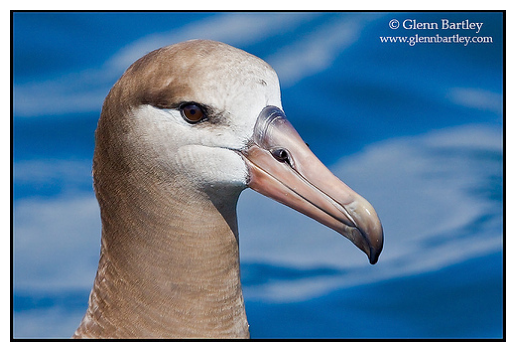

In [4]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('D:\TorchProject\dataset\cub\CUB_200_2011\images\\001.Black_footed_Albatross\Black_Footed_Albatross_0046_18.jpg')  # Replace with the actual path to your image

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()



def visualize_nodes_on_images(graph, image_paths):
    for node_id, node_data in graph.nodes(data=True):
        if "x" in node_data and "y" in node_data:
            x, y = node_data["x"], node_data["y"]
            image_path = image_paths[node_id - 1]  # Assuming node_id is 1-based
            image = cv2.imread(image_path)

            # Draw a red circle on the image to represent the node
            cv2.circle(image, (x, y), 5, (0, 0, 255), -1)

            # Display the image with the node visualization
            cv2.imshow(f"Node {node_id} Visualization", image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

if __name__ == "__main__":
    root_dir = 'D:\TorchProject\dataset\cub\CUB_200_2011'
    image_paths = [os.path.join(root_dir, f"{i:03d}.jpg") for i in range(1, 217)]  # Adjust this based on your image filenames

    graph_construct = Graph_construct()

    # ... (rest of your code)

    visualize_nodes_on_images(graph_construct.graph, image_paths)

